## This code will recommend games to a player using reviews each game received from each player and what games that player played the most.

In order to test this, please write a player's steam game id in to the input. If nothing is written, the default id will be placed to run the code

In [1]:
test_id=76561198141485825

We will first gather game review data from STEAM using API.

In [2]:
import requests
# Get all the games that the player played
def getownedgames(idnum):
    """Takes the id number of a steam user and returns the id num of games they own"""
    url='http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key=3A629E52AE594CB777253431189F2967&steamid={}&format=json'.format(idnum)
    r=requests.get(url)
    json_data=r.json()
    return json_data

In [3]:
def get_reviews(gameid,num):
    """Takes the id number of a game and returns 20 reviews"""
    url='http://store.steampowered.com/appreviews/{}?json=1&start_offset={} '.format(gameid,num)
    r=requests.get(url)
    json_data=r.json()
    return json_data

In [4]:
import pandas as pd
def get_all_reviews(gameid):
    """Uses 'get_review' function to pull as many reviews as it can from steam website"""
    """STEAM website usually have limitation (20 reviews) on how many reviews we can pull"""
    n=0
    stop=0
    fst_iterat=get_reviews(gameid,n)
    if fst_iterat['success']==1:
        df=pd.DataFrame(fst_iterat['reviews'])
        numreview=fst_iterat['query_summary']['num_reviews']             
        while numreview==20:
            if len(df)>=120:
                break
            n+=20
            add_iterat=get_reviews(gameid,n)
            df_add=pd.DataFrame(add_iterat['reviews'])
            df=df.append(df_add)
            numreview=add_iterat['query_summary']['num_reviews']
        df_author=pd.DataFrame(df['author'].tolist())
        df['author']=df_author['steamid']
    return df[['author','recommendationid','language','review']]

Get all the application id that is on STEAM website.

In [5]:
api_key='3A629E52AE594CB777253431189F2967' # API key for getting information from Steam
allgame='http://api.steampowered.com/ISteamApps/GetAppList/v0002/?key={}&format=json'.format(api_key)
all_r=requests.get(allgame)
allgame_id=all_r.json()

In [6]:
steamapp_dict=dict()
for num in range(len(allgame_id['applist']['apps'])):
    key=allgame_id['applist']['apps'][num]['appid']
    value=allgame_id['applist']['apps'][num]['name']
    if key in steamapp_dict:
        continue
    else:
        steamapp_dict[key]=value

In [7]:
steamapp_dict[10]

'Counter-Strike'

In [8]:
len(steamapp_dict)

77526

Stopwords including punctuation and version codes are removed

In [9]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

all_stops = stopwords.words('english')+list(string.punctuation)+['I','II','III','IV','V','VI','game','games','play']

filter out words that are included in stopwords and the words that are composed of numbers (e.g.1,2,3,4,5, ... )

In [10]:
import pickle

Now that we have the database to get games from, we will test it with a player.

In [11]:
file_name='steam_review_bulk.p'

In [12]:
review_df=pickle.load(open(file_name,"rb"))

In [13]:
review_df.head(10)

,author,comment_count,language,received_for_free,recommendationid,review,steam_purchase,timestamp_created,timestamp_updated,voted_up,votes_funny,votes_up,weighted_vote_score,written_during_early_access,game_name,developer_response,timestamp_dev_responded
0,76561198418549470,2,english,False,48738870,"Well, I had never played a time-management gam...",True,1549214430,1549236308,True,0,9,0.589138209819793701,False,Elven Legend,NaN,NaN
1,76561198044857549,0,english,False,30095674,This is the third time I have had to leave a r...,True,1487755088,1487755088,False,0,28,0.807962000370025635,False,Bequest,NaN,NaN
2,76561198030980450,0,english,False,49686292,has potiential. needs more cultures as well. h...,True,1553224936,1553224936,True,0,1,0.444444417953491211,False,Empire Architect,NaN,NaN
3,76561198129998583,0,english,False,45343379,Trash.,True,1539976440,1539976440,False,0,1,0.482841163873672485,False,Jelly in the sky,NaN,NaN
4,76561198135538727,0,english,False,48179714,"Not made for 1080p or higher, since text and i...",True,1546910395,1546910395,False,0,1,0.533527672290802002,False,The Last Cargo,NaN,NaN
5,76561198194666093,1,english,False,33891613,I like twin stick shooters and this is a very ...,True,1501367283,1501367283,True,0,4,0.53712773323059082,False,Rocking Pilot,NaN,NaN
6,76561198010477461,1,english,False,33532249,Good core gameplay. Using propellers as a weap...,True,1500024969,1500024969,True,0,3,0.525065958499908447,False,Rocking Pilot,NaN,NaN
7,76561198255088411,0,english,False,40226172,"A ridiculously fun, very difficult twin-stick ...",True,1519053398,1519053398,True,0,2,0.530916869640350342,False,Rocking Pilot,NaN,NaN
8,76561198115152625,1,english,False,31888896,Great bullet hell game!\nGame is a real adrena...,True,1495393077,1495393077,True,0,4,0.423531502485275269,False,Rocking Pilot,NaN,NaN
9,76561197965255029,1,english,False,32707257,Funny Game! I really loved the one helicopter ...,True,1498271275,1498271275,True,0,0,0,False,Rocking Pilot,NaN,NaN


In [14]:
review_df=review_df[['author','language','review','game_name']]
review_df=review_df.drop_duplicates()

In [15]:
from langdetect import detect

In [16]:
from langdetect import DetectorFactory 
DetectorFactory.seed = 0

In [17]:
lang=list()
for num in range(len(review_df['review'])):
    try: 
        detected=detect(review_df['review'][num])
        lang.append(detected)
    except:
        lang.append('NaN')

In [18]:
review_df['detected_lang']=lang
review_df=review_df[review_df['detected_lang']=='en']

Define function to take all the review data into documents; one review document from each game

In [19]:
def amalgamate(df):
    dumped_dict=dict()
    for name in df['game_name'].unique():
        dump=df.loc[(df['game_name']==name)]['review'].sum(axis=0)
        dumped_dict[name]=dump
    return dumped_dict

In [20]:
allgamedatabase=amalgamate(review_df)

In [21]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

                   review
author                   
76561198066590240     144
76561198069159152     127
76561198019816374      96
76561198120348301      54
76561198053422627      53
76561198048974498      52
76561198035285721      47
76561198040884867      44
76561198059971262      38
76561198063942102      37


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001856B78E400>]],
      dtype=object)

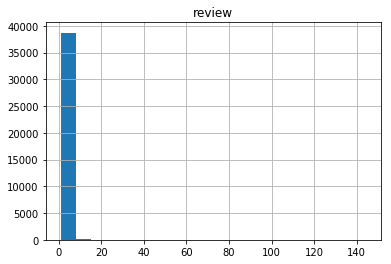

In [22]:
reviewauthor=review_df.groupby(['author']).agg({'review':'count'})
reviewauthor_new=reviewauthor.reset_index().sort_values('review',ascending=False).set_index('author')
print(reviewauthor_new[0:10])
reviewauthor_new.hist(bins=20)

                                 review
game_name                              
Artifact                            113
Factorio                            110
Undertale                            96
Metro Exodus                         89
Black Desert Online SA               88
Elite Dangerous                      80
Hearts of Iron IV: Man the Guns      78
DOOM                                 69
Vampyr                               69
Freeman: Guerrilla Warfare           68


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001856B656978>]],
      dtype=object)

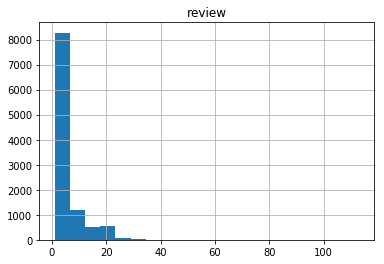

In [23]:
reviewgame=review_df.groupby(['game_name']).agg({'review':'count'})
reviewgame_new=reviewgame.reset_index().sort_values('review',ascending=False).set_index('game_name')
print(reviewgame_new[0:10])
reviewgame_new.hist(bins=20)

Although most people only leave 1 or 2 reviews, the most active player left upto 304 reviews

save the game data of a player in the variable: testperson
extract the game ids and the time the player spent on each game: testids, testplaytimes

In [24]:
def rawplayergamelist(_id):
    gamelist=getownedgames(_id)['response']['games']
    return gamelist

In [25]:
testperson=rawplayergamelist(test_id)

In [27]:
testids=list()
testplaytimes=list()
for i in range(len(testperson)):
    testids.append(testperson[i]['appid'])
    testplaytimes.append(testperson[i]['playtime_forever'])

In [28]:
test_df=pd.DataFrame(list(zip(testids,testplaytimes)),columns=['ids','playtime']).sort_values('playtime',ascending=False)
playedgame_name=list()
for id_ in test_df['ids']:
    name=steamapp_dict.get(id_)
    playedgame_name.append(name)
test_df['name']=playedgame_name

select the games that are present in the database we set up for this analysis and make a new dataframe comprised of playtime and game ids: test_df

In [29]:
test_df.head()

,ids,playtime,name
27,72850,38145,The Elder Scrolls V: Skyrim
53,219740,10490,Don't Starve
15,33230,5768,Assassin's Creed II
39,317110,5524,Uncharted Waters Online: Episode Atlantis
32,242050,4405,Assassin's Creed IV Black Flag


pick most played game in the list and retreive all the reviews that are present there : player_df

default number of games is 15 but if the player played less than 15 games, it will adjust to the games that the player played for at least 30 minutes

In [30]:
if len(test_df[test_df['playtime']>=30])<15:
    topplayedgame=test_df[test_df['playtime']>=30]
else:
    topplayedgame=test_df[0:15]

In [31]:
topplayedgame=topplayedgame.set_index('ids')

In [32]:
topplayedgame.index

Int64Index([ 72850, 219740,  33230, 317110, 242050,  22330,  48190, 413150,
            391540, 205100, 311560, 208480, 368500, 201870, 261570],
           dtype='int64', name='ids')

get all reviews of the games this player enjoys: player_df

In [33]:
error=list()
for ids in topplayedgame.index:
    try:
        data=get_all_reviews(ids)
        data['game_name']=steamapp_dict.get(ids)
        if 'player_df' not in locals():
            player_df=data
        else:
            player_df=player_df.append(data, ignore_index=True, sort=False)
    except:
        error.append(ids)
        topplayedgame['name']

C:\Users\shshi\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [34]:
topplayedgame=topplayedgame.drop(error)

In [35]:
topplayedgame

,playtime,name
ids,,
72850,38145,The Elder Scrolls V: Skyrim
219740,10490,Don't Starve
33230,5768,Assassin's Creed II
242050,4405,Assassin's Creed IV Black Flag
22330,3391,The Elder Scrolls IV: Oblivion
48190,2773,Assassin's Creed Brotherhood
413150,2250,Stardew Valley
391540,1726,Undertale
205100,1542,Dishonored


In [36]:
player_df.head()

,author,recommendationid,language,review,game_name
0,76561198170531813,49743905,english,DLC Page\n-------------\n\nhttps://store.steam...,The Elder Scrolls V: Skyrim
1,76561198067648820,49771800,english,"If you want the original Skyrim game + DLCs,\n...",The Elder Scrolls V: Skyrim
2,76561198122616211,49603949,english,Bethesda gay but Skyrim good,The Elder Scrolls V: Skyrim
3,76561198014269840,49571483,english,"Is Skyrim, what else do i need to say? Just pl...",The Elder Scrolls V: Skyrim
4,76561198356347715,49866950,english,This game started in the same year I got marri...,The Elder Scrolls V: Skyrim


In order to use cosine similarity to compare these lists to other games, all the reviews from each games are made into one big corpus. i.e. one corpus each for all the game respectively.

In [37]:
player_dict=amalgamate(player_df)

In [38]:
player_dict.keys()

dict_keys(['The Elder Scrolls V: Skyrim', "Don't Starve", "Assassin's Creed II", "Assassin's Creed IV Black Flag", 'The Elder Scrolls IV: Oblivion ', "Assassin's Creed Brotherhood", 'Stardew Valley', 'Undertale', 'Dishonored', "Assassin's Creed Rogue", "Assassin's Creed® III", "Assassin's Creed Syndicate", "Assassin's Creed Revelations", 'Ori and the Blind Forest'])

In [39]:
for_analysis={**allgamedatabase,**player_dict}

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk.stem

In [41]:
import re
stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

vectorizer_s = StemmedCountVectorizer(analyzer="word", stop_words=all_stops,ngram_range=(1,2),min_df=0.01,token_pattern=r'\b[^\d\W]+\b')

In [42]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

tfidf_s = StemmedTfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word', stop_words=all_stops,ngram_range=(1,2),min_df=0.01,token_pattern=r'\b[^\d\W]+\b')

In [86]:
text=player_df.review.sum(axis=0)

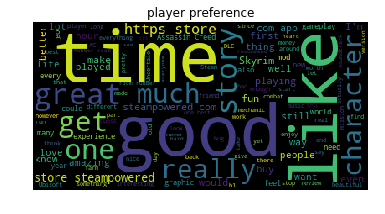

In [90]:
wordcloud=WordCloud(stopwords=all_stops).generate(text)
plt.axis('off')
plt.title('player preference')
plt.imshow(wordcloud)

From all the games this player played, the term "story" pops up quite a lot giving us a clue that this player enjoys games that has story element to it. They may like a game that has a lot of characters.

"time" also shows up quite a lot but it is unsure just from this wordcloud whether that means a game that takes a lot of time to play or the opposite.




<br>
Using only the stems of each words, I calculate the TF-IDF scores of the reviews

In [45]:
def stemvect(text):
    X=vectorizer_s.fit_transform(text)
    return X.toarray(), vectorizer_s.get_feature_names()

In [46]:
def stemtfidf(text):
    X=tfidf_s.fit_transform(text)
    return X.toarray(),tfidf_s.get_feature_names()

In [47]:
freq,words=stemvect(for_analysis.values())
tdfscore,tdfwords=stemtfidf(for_analysis.values())

In [48]:
games_tdf=pd.DataFrame(tdfscore,index=for_analysis.keys(),columns=tdfwords)

In [49]:
games_tdf.head()

,aaa,abandon,abil,abl,able get,absolut,absolutely lov,accept,access,accid,...,yes,yet,young,youtu,youtub,youtube com,zero,zombi,zone,zoom
Elven Legend,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Bequest,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.755878,0.0,0.0,0.0,0.0,0.0,0.0
Empire Architect,0.0,4.594776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Jelly in the sky,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
The Last Cargo,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


These will in turn be used to calculate cosine similarity with each other: matrixforgame

This allows us to find out how similar each game's reviews are to others, which in turn implies how similar each game is to the other

In [50]:
list_of_games=games_tdf.index.tolist()
listlength=len(list_of_games)
import numpy as np
from scipy import spatial
matrixforgame=np.zeros(shape=(listlength,listlength))
for i in range(len(list_of_games)):
    game=list_of_games[i]
    for j in range(len(list_of_games)):
        another=list_of_games[j]
        if game!=another:
            result=1-spatial.distance.cosine(games_tdf.loc[game].values,games_tdf.loc[another].values)
            matrixforgame[i][j]=result

C:\Users\shshi\Anaconda3\lib\site-packages\scipy\spatial\distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [51]:
result_df=pd.DataFrame(matrixforgame,index=list_of_games,columns=list_of_games)

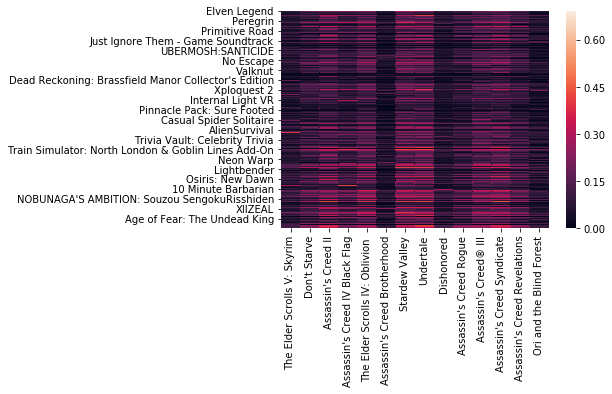

In [52]:
import seaborn as sns
sns.heatmap(result_df[topplayedgame['name']])

You can see as a heat map that there were a lot more games similar to Undertale than Assassins's Creed Brotherhood.<br>
There also seem to be a small number of game that was very similar to Ori and the Blind Forest as there is one bright band.


<br>
<br>

I added weight to each games according to how long the player played it for and added all the cosine similarity values: result_df<br>
This allows me to get a list of games that this player is likely to enjoy because they played these list of games a lot.

In [53]:
weight=len(list(player_dict.keys()))
result_df['total'] = 0
for name in player_df['game_name'].unique():
    result_df['total']=result_df['total']+(weight*result_df[name])
    weight=weight-1

remove the games that this player already possess: removed<br>
Then we take the top 10 games with the largest similarity: finaltop10recommendation

In [54]:
alreadyownedgames=test_df['name'].tolist()
removed=[name for name in result_df.index.tolist() if name not in alreadyownedgames]

In [65]:
finaltop10recommendation=result_df['total'].loc[removed].sort_values(ascending=False)[0:10]
final_list=finaltop10recommendation.index.tolist()

To give users accessibility, I added in urls to each recommended game and presented them: recommended_games

In [66]:
recommended_games=list()
for name in final_list:
    ids=list(steamapp_dict.keys())[list(steamapp_dict.values()).index(name)]
    recommended_games.append((name,"https://store.steampowered.com/app/"+str(ids)))

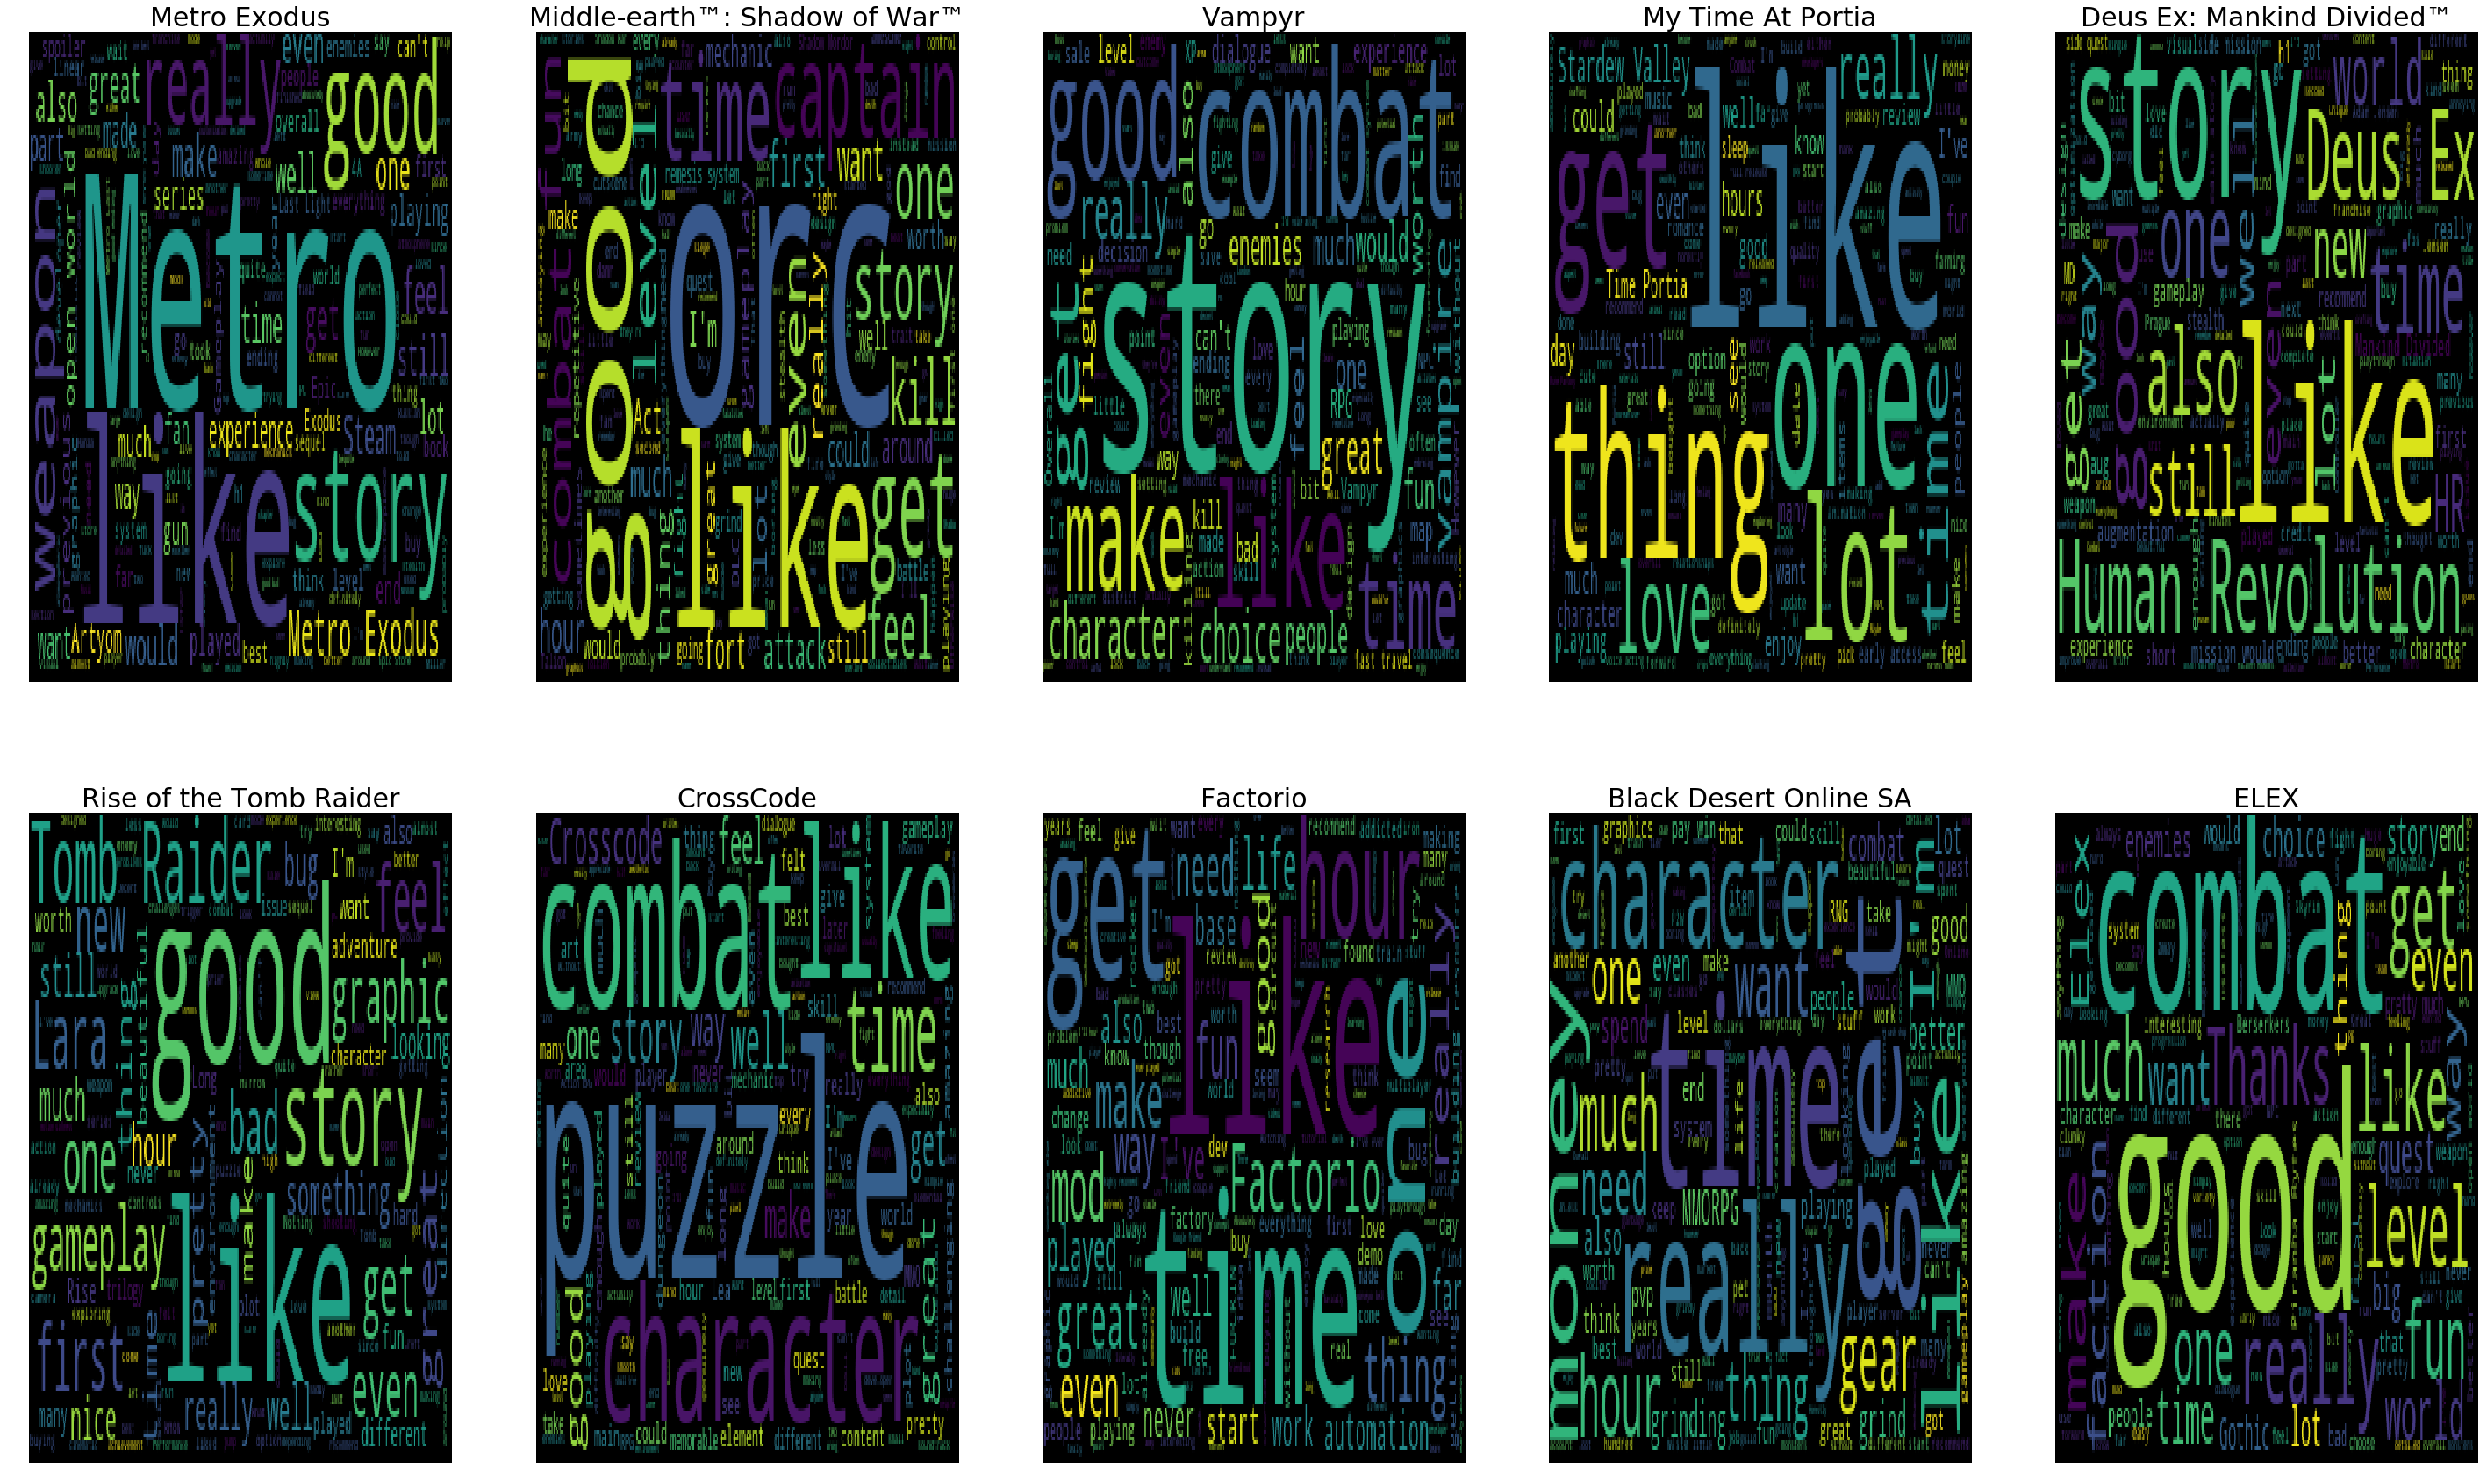

In [68]:
plot_num=1
plt.figure(figsize = (50,30))
for name in final_list:
    working_data=review_df[review_df['game_name']==name]
    text=working_data.review.sum(axis=0)
    wordcloud=WordCloud(stopwords=all_stops).generate(text)
    plt.subplot(2, 5, plot_num)
    plt.gca().set_title(name, fontsize=30)
    plt.imshow(wordcloud,aspect='auto')
    plt.axis('off')
    plot_num=plot_num+1

In [91]:
print("\nBecause you played games such as {}, {} and {}, \n you will like these games as well!\n".format(alreadyownedgames[0],alreadyownedgames[1],alreadyownedgames[2]))
print(pd.DataFrame(recommended_games,columns=["Game Name","Store page"]))


Because you played games such as The Elder Scrolls V: Skyrim, Don't Starve and Assassin's Creed II, 
 you will like these games as well!

                       Game Name                                 Store page
0                   Metro Exodus  https://store.steampowered.com/app/412020
1  Middle-earth™: Shadow of War™  https://store.steampowered.com/app/356190
2                         Vampyr  https://store.steampowered.com/app/427290
3              My Time At Portia  https://store.steampowered.com/app/666140
4      Deus Ex: Mankind Divided™  https://store.steampowered.com/app/337000
5        Rise of the Tomb Raider  https://store.steampowered.com/app/391220
6                      CrossCode  https://store.steampowered.com/app/368340
7                       Factorio  https://store.steampowered.com/app/427520
8         Black Desert Online SA  https://store.steampowered.com/app/706220
9                           ELEX  https://store.steampowered.com/app/411300
